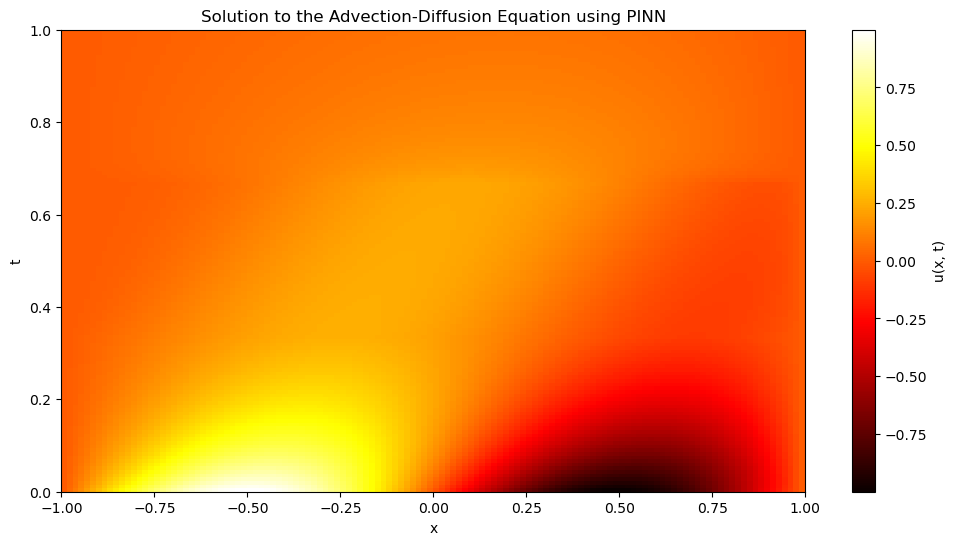

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Ensure that animations display properly in the notebook
%matplotlib inline

# Define spatial parameters
x_min = -1.0
x_max = 1.0
Nx = 128          # Spatial resolution
x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]

# Advection speed
c = 1.0

# Adjust dt based on CFL condition for advection
dt_max = dx / c
dt = dt_max * 0.5  # Use 50% of the maximum allowable dt for stability

# Define time intervals
t0 = 0.0
t1 = 1.0 / 3.0
t2 = 2.0 / 3.0
t3 = 1.0

# Calculate the number of time steps for each interval
Nt1 = int((t1 - t0) / dt) + 1
Nt2 = int((t2 - t1) / dt) + 1
Nt3 = int((t3 - t2) / dt) + 1

# Recalculate dt to fit the time intervals exactly
dt1 = (t1 - t0) / (Nt1 - 1)
dt2 = (t2 - t1) / (Nt2 - 1)
dt3 = (t3 - t2) / (Nt3 - 1)

# Time vectors for each interval
t_interval1 = np.linspace(t0, t1, Nt1)
t_interval2 = np.linspace(t1, t2, Nt2)
t_interval3 = np.linspace(t2, t3, Nt3)

# Combine time vectors for plotting, removing duplicate points at overlaps
t = np.concatenate((t_interval1[:-1], t_interval2[:-1], t_interval3))

# Initialize solution array with adjusted size
Nt_combined = Nt1 + Nt2 + Nt3 - 2  # Subtract overlaps
u_total = np.zeros((Nt_combined, Nx))

# New initial condition: u(t=0, x) = -sin(π x)
u0 = -np.sin(np.pi * x)
u_total[0, :] = u0

# Boundary conditions (already satisfied by the initial condition)
u_total[:, 0] = 0.0     # u(-1, t) = 0
u_total[:, -1] = 0.0    # u(1, t) = 0

# Function to solve the PDE over a given interval
def solve_interval(u_initial, t_start, t_end, Nt_interval, lambda_n, dt_interval):
    dt = dt_interval
    CFL_advection = c * dt / dx
    if CFL_advection > 1.0:
        print(f"Warning: CFL condition for advection not satisfied in interval [{t_start}, {t_end}]. Adjust dt or dx for stability.")

    u = np.zeros((Nt_interval, Nx))
    u[0, :] = u_initial
    u[:, 0] = 0.0     # Boundary condition at x=0
    u[:, -1] = 0.0    # Boundary condition at x=1

    # Coefficient for diffusion term
    a = lambda_n * dt / dx**2

    # Time-stepping
    for n in range(0, Nt_interval - 1):
        # Coefficients for the tridiagonal matrix
        lower = -a * np.ones(Nx - 3)
        main = (1 + 2 * a) * np.ones(Nx - 2)
        upper = -a * np.ones(Nx - 3)

        # Build RHS of the system
        RHS = u[n, 1:-1] - dt * (u[n, 1:-1] - u[n, 0:-2]) / dx

        # Forward sweep (Thomas algorithm)
        for j in range(1, Nx - 2):
            w = lower[j - 1] / main[j - 1]
            main[j] = main[j] - w * upper[j - 1]
            RHS[j] = RHS[j] - w * RHS[j - 1]

        # Back substitution
        u_new = np.zeros(Nx - 2)
        u_new[-1] = RHS[-1] / main[-1]
        for j in range(Nx - 4, -1, -1):
            u_new[j] = (RHS[j] - upper[j] * u_new[j + 1]) / main[j]

        # Update solution
        u[n + 1, 1:-1] = u_new

    return u

# Solve over the first interval [t0, t1]
lambda1 = 0.5
u_interval1 = solve_interval(u_total[0, :], t0, t1, Nt1, lambda1, dt1)
u_total[0:Nt1, :] = u_interval1

# Solve over the second interval [t1, t2]
lambda2 = 0.05
u_initial2 = u_interval1[-1, :] #Initial condition for second interval is the final time configuration of the first interval solution
u_interval2 = solve_interval(u_initial2, t1, t2, Nt2, lambda2, dt2)
u_total[Nt1 - 1:Nt1 + Nt2 - 1, :] = u_interval2

# Solve over the third interval [t2, t3]
lambda3 = 1.0
u_initial3 = u_interval2[-1, :]
u_interval3 = solve_interval(u_initial3, t2, t3, Nt3, lambda3, dt3)
u_total[Nt1 + Nt2 - 2:, :] = u_interval3
'''
# Prepare the data for animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], lw=2)
ax.set_xlim(x_min, x_max)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('Spatial Coordinate x')
ax.set_ylabel('u(x, t)')
ax.set_title('Evolution of u(x, t) Over Time')

# Initialize function for animation
def init():
    line.set_data([], [])
    return line,

# Animation function
def animate(i):
    y = u_total[i, :]
    line.set_data(x, y)
    ax.set_title(f'Evolution of u(x, t) at t = {t[i]:.3f}')
    return line,

# Create the animation
frame_interval = 1  # Adjust this to control the speed of the animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt_combined, interval=frame_interval, blit=True)

# Display the animation in the notebook
HTML(anim.to_jshtml())
'''
plt.figure(figsize=(12, 6))
plt.imshow(u_total, extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Advection-Diffusion Equation using PINN')
plt.show()

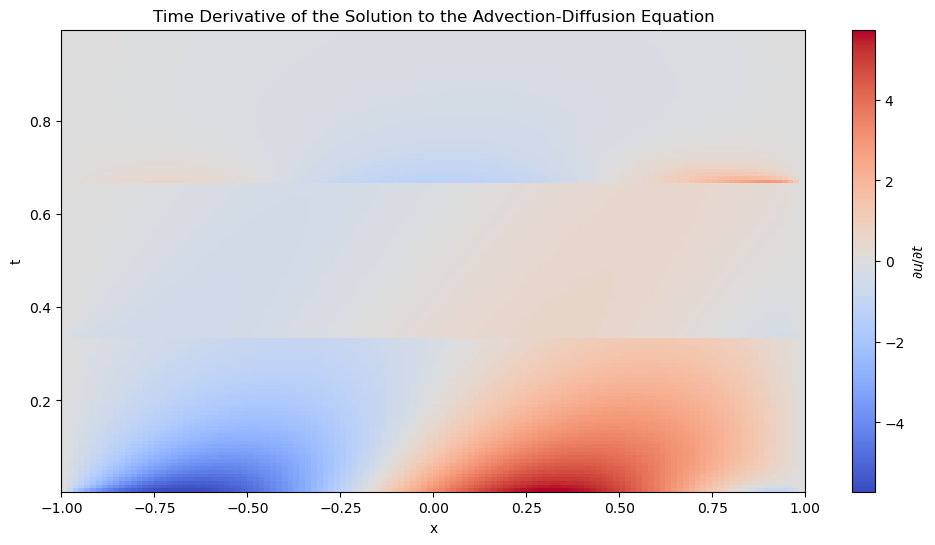

In [3]:
# Calculate the time derivative of u_total
du_total_dt = np.diff(u_total, axis=0) / dt  # Central difference in time

# Prepare the time vector for the derivative (midpoints between original time steps)
t_derivative = 0.5 * (t[:-1] + t[1:])

# Plot the time derivative of u_total
plt.figure(figsize=(12, 6))
plt.imshow(
    du_total_dt,
    extent=[x_min, x_max, t_derivative[0], t_derivative[-1]],
    origin='lower',
    aspect='auto',
    cmap='coolwarm',
)
plt.colorbar(label=r'$\partial u / \partial t$')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Time Derivative of the Solution to the Advection-Diffusion Equation')
plt.show()


In [5]:
# Calculate the number of time steps for each interval
Nt1 = int((t1 - t0) / dt) + 1
Nt2 = int((t2 - t1) / dt) + 1
Nt3 = int((t3 - t2) / dt) + 1
print(Nt1,Nt2,Nt3)
# Recalculate dt to fit the time intervals exactly
dt1 = (t1 - t0) / (Nt1 - 1)
dt2 = (t2 - t1) / (Nt2 - 1)
dt3 = (t3 - t2) / (Nt3 - 1)
print(dt1,dt2,dt3)

# Time vectors for each interval
t_interval1 = np.linspace(t0, t1, Nt1)
t_interval2 = np.linspace(t1, t2, Nt2)
t_interval3 = np.linspace(t2, t3, Nt3)
print(t_interval1.shape,t_interval2.shape,t_interval3.shape)

43 43 43
0.007936507936507936 0.007936507936507936 0.007936507936507938
(43,) (43,) (43,)


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Parameters
learning_rate = 0.0001
eta = learning_rate
num_epochs = 30000

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the domain for x and t
x_values = np.linspace(-1, 1, Nx)
t_values = np.linspace(0, 1, Nt_combined)
X, T = np.meshgrid(x_values, t_values)
x_t_grid = torch.tensor(np.c_[X.ravel(), T.ravel()], dtype=torch.float32).to(device)
# Get the total number of x values in each t slice (201 in your case)
num_x_values = x_values.shape[0] #201
N_total = Nx*Nt_combined
# Extract the first occurrence of each time value by taking a slice with step `num_x_values`
t_grid = x_t_grid[::num_x_values, 1]
t_grid = t_grid.unsqueeze(1)

#Defining Spatial Batches
Batches = []
for i in range(Nx):
    # Find indices in x_t_grid corresponding to the i-th x point
    indices = (x_t_grid[:, 0] == x_values[i])
    # Select all (x, t) points for the current x value
    Batch = x_t_grid[indices]
    Batches.append(Batch)

from torch.utils.data import Dataset

class GridDataset(Dataset):
    def __init__(self, x_t_grid, x_values, u_total):
        
        self.x_t_grid = x_t_grid
        self.x_values = x_values
        self.u_total = u_total

    def __len__(self):
        
        return len(self.x_values)

    def __getitem__(self, idx):
    
        x_value = self.x_values[idx]
        indices = (self.x_t_grid[:, 0] == x_value)
        batch = self.x_t_grid[indices]
        u_values = self.u_total[:,idx]
        
        # Convert to torch tensors
        u_values_tensor = torch.tensor(u_values, dtype=torch.float32,device=device)
        
        return batch, u_values_tensor

# Create dataset and dataloader
grid_dataset = GridDataset(x_t_grid, x_values,u_total)
dataloader = DataLoader(grid_dataset, batch_size=32, shuffle=True)

Using device: cuda


In [153]:
items[0]

tensor([[[-0.4173,  0.0000],
         [-0.4173,  0.0079],
         [-0.4173,  0.0159],
         ...,
         [-0.4173,  0.9841],
         [-0.4173,  0.9921],
         [-0.4173,  1.0000]],

        [[ 0.7323,  0.0000],
         [ 0.7323,  0.0079],
         [ 0.7323,  0.0159],
         ...,
         [ 0.7323,  0.9841],
         [ 0.7323,  0.9921],
         [ 0.7323,  1.0000]],

        [[-0.6220,  0.0000],
         [-0.6220,  0.0079],
         [-0.6220,  0.0159],
         ...,
         [-0.6220,  0.9841],
         [-0.6220,  0.9921],
         [-0.6220,  1.0000]],

        ...,

        [[-0.9685,  0.0000],
         [-0.9685,  0.0079],
         [-0.9685,  0.0159],
         ...,
         [-0.9685,  0.9841],
         [-0.9685,  0.9921],
         [-0.9685,  1.0000]],

        [[-0.4331,  0.0000],
         [-0.4331,  0.0079],
         [-0.4331,  0.0159],
         ...,
         [-0.4331,  0.9841],
         [-0.4331,  0.9921],
         [-0.4331,  1.0000]],

        [[-0.5906,  0.0000],
       

In [143]:
x_t_grid[:,0]

tensor([-1.0000, -0.9843, -0.9685,  ...,  0.9685,  0.9843,  1.0000],
       device='cuda:0')

In [117]:
x_t_grid.reshape(127,128,2)

tensor([[[-1.0000,  0.0000],
         [-0.9843,  0.0000],
         [-0.9685,  0.0000],
         ...,
         [ 0.9685,  0.0000],
         [ 0.9843,  0.0000],
         [ 1.0000,  0.0000]],

        [[-1.0000,  0.0079],
         [-0.9843,  0.0079],
         [-0.9685,  0.0079],
         ...,
         [ 0.9685,  0.0079],
         [ 0.9843,  0.0079],
         [ 1.0000,  0.0079]],

        [[-1.0000,  0.0159],
         [-0.9843,  0.0159],
         [-0.9685,  0.0159],
         ...,
         [ 0.9685,  0.0159],
         [ 0.9843,  0.0159],
         [ 1.0000,  0.0159]],

        ...,

        [[-1.0000,  0.9841],
         [-0.9843,  0.9841],
         [-0.9685,  0.9841],
         ...,
         [ 0.9685,  0.9841],
         [ 0.9843,  0.9841],
         [ 1.0000,  0.9841]],

        [[-1.0000,  0.9921],
         [-0.9843,  0.9921],
         [-0.9685,  0.9921],
         ...,
         [ 0.9685,  0.9921],
         [ 0.9843,  0.9921],
         [ 1.0000,  0.9921]],

        [[-1.0000,  1.0000],
       

In [119]:
# Print contents of the DataLoader
for index, items in enumerate(dataloader):
    print(items[0].shape, items[1].shape)

torch.Size([32, 127, 2]) torch.Size([32, 127])
torch.Size([32, 127, 2]) torch.Size([32, 127])
torch.Size([32, 127, 2]) torch.Size([32, 127])
torch.Size([32, 127, 2]) torch.Size([32, 127])


In [123]:
items[1]

tensor([[ 0.9665,  0.9356,  0.9052,  ...,  0.0489,  0.0478,  0.0468],
        [-0.7453, -0.7325, -0.7184,  ...,  0.0446,  0.0437,  0.0428],
        [ 0.9274,  0.8830,  0.8403,  ...,  0.0311,  0.0304,  0.0298],
        ...,
        [ 0.0988,  0.0857,  0.0776,  ...,  0.0023,  0.0023,  0.0022],
        [ 0.9780,  0.9456,  0.9136,  ...,  0.0475,  0.0465,  0.0455],
        [ 0.9598,  0.9164,  0.8744,  ...,  0.0339,  0.0331,  0.0324]],
       device='cuda:0')

In [125]:
items[1].shape

torch.Size([32, 127])

In [231]:
b=50.0


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
b=10.0
class GELU_PINN(nn.Module):
    def __init__(self):
        super(GELU_PINN, self).__init__()  # Corrected class name
        
        # Network for u(x, t)
        self.fc1_u = nn.Linear(2, 200)
        self.fc2_u = nn.Linear(200, 200)
        self.fc3_u = nn.Linear(200, 200)
        self.fc4_u = nn.Linear(200, 200)
        self.fc5_u = nn.Linear(200, 200)
        self.fc6_u = nn.Linear(200, 1)
        
    def forward(self, x):
        # Predict u(x, t) using the full (x, t) input
        u = F.softplus(self.fc1_u(x),beta=b)
        u = F.softplus(self.fc2_u(u),beta=b)
        u = F.softplus(self.fc3_u(u),beta=b)
        u = F.softplus(self.fc4_u(u),beta=b)
        u = F.softplus(self.fc5_u(u),beta=b)
        u = self.fc6_u(u)
        
        return u

# Create the updated model
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_updated = GELU_PINN().to(device)

# Load the checkpoint
checkpoint = torch.load("gelu_pinn_model2.pth")

# Restore the weights into the updated model
model_updated.load_state_dict(checkpoint['model_state_dict'])

# Restore optimizer and training state
optimizer = optim.Adam(list(model_updated.parameters()), lr=1e-3)  # Replace `1e-3` with your learning rate
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
last_loss = checkpoint['loss']  # Last loss value

print(f"Checkpoint loaded into updated model. Resuming training from epoch {start_epoch}. Last loss: {last_loss}")


C:\Users\yaman\AppData\Local\Temp\ipykernel_18340\883573106.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("gelu_pinn_model2.pth")


Checkpoint loaded into updated model. Resuming training from epoch 17939. Last loss: 0.00038239776040427387


In [11]:
learning_rate = 0.00001
eta = learning_rate
optimizer = optim.Adam(list(model_updated.parameters()), lr=eta)

In [247]:
optimizer = optim.LBFGS(model_updated.parameters(), lr=1.0, max_iter=500, tolerance_grad=1e-5)

In [13]:
def training_loss(model,batch):
    x_t = batch[0]
    u_pred = model(x_t)[:,:,0]
    u_train = batch[1]
    return torch.sum((u_pred - u_train)**2)

In [83]:
training_loss(model_updated,items)

tensor(0.0171, device='cuda:0', grad_fn=<SumBackward0>)

NameError: name 'loss' is not defined

In [288]:
def closure():
    # Recompute the forward pass to get the latest gradients
    optimizer.zero_grad()  # Clear gradients
    loss = training_loss(model_updated, batch)  # Compute the loss
    if not loss.requires_grad:
        raise ValueError("Loss does not require gradients. Check model and inputs.")
    loss.backward()  # Compute gradients
    return loss

L_train = optimizer.step(closure)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [263]:


for epoch in range(num_epochs):
    loss_train = torch.tensor(0.0, requires_grad=False, device = device)  # Initialize as a tensor

    for index, batch in enumerate(dataloader):
        x_t_batch = batch[0]
        u_batch = batch[1]
        
        # Perform the optimizer step
        L_train = optimizer.step(closure)  # Step using LBFGS
        loss_train += L_train  # Accumulate loss as a tensor
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Training Loss: {loss_train.item()}")


TypeError: sub(): argument 'other' (position 1) must be Tensor, not NoneType

In [ ]:
for epoch in range(30000):
    
    loss_train = 0
    for index, batch in enumerate(dataloader):
        
        x_t_batch = batch[0]
        u_batch = batch[1]
        
        L_train = training_loss(model_updated,batch)
                
        optimizer.zero_grad()
        L_total = L_train
        loss_train += L_train
        
        # Step 3: Backpropagate to compute gradients
        L_total.backward()
        
        # Step 4: Perform the gradient descent step
        optimizer.step()
        
    if epoch%100==99:
        print(f"epochs:{epoch} , Loss:{loss_train}")

epochs:99 , Loss:0.0011625802144408226
epochs:199 , Loss:0.001153887016698718
epochs:299 , Loss:0.0011780322529375553
epochs:399 , Loss:0.0012823832221329212
epochs:499 , Loss:0.0015192225109785795
epochs:599 , Loss:0.001134510152041912
epochs:699 , Loss:0.0011005615815520287
epochs:799 , Loss:0.0011207656934857368
epochs:899 , Loss:0.0012361719273030758
epochs:999 , Loss:0.0010878090979531407
epochs:1099 , Loss:0.0010973167372867465
epochs:1199 , Loss:0.0010684682056307793
epochs:1299 , Loss:0.0011086906306445599
epochs:1399 , Loss:0.0010681177955120802
epochs:1499 , Loss:0.0010652017081156373
epochs:1599 , Loss:0.0012286724522709846
epochs:1699 , Loss:0.00108585215639323
epochs:1799 , Loss:0.0010305523173883557
epochs:1899 , Loss:0.0010108327260240912
epochs:1999 , Loss:0.0010192720219492912
epochs:2099 , Loss:0.0010180824901908636
epochs:2199 , Loss:0.000997982919216156
epochs:2299 , Loss:0.0010197155643254519
epochs:2399 , Loss:0.001015277812257409
epochs:2499 , Loss:0.000966363295

In [ ]:
# Filepath to save the model
model_save_path = "gelu_pinn_model2.pth"

# Save the model's state_dict (parameters)
torch.save({
    'model_state_dict': model_updated.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': loss_train,
}, model_save_path)

print(f"Model saved to {model_save_path}")


In [241]:
loss_train

tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)

In [161]:
u_pred.shape

(127, 128)

In [165]:
u_total.shape

(127, 128)

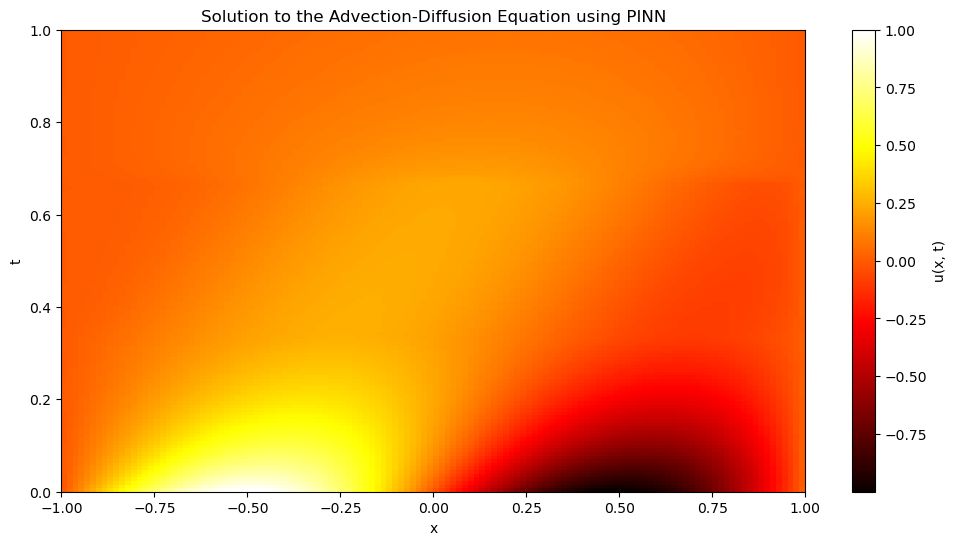

In [15]:
tensor = model_updated(x_t_grid).reshape(127,128)

# Convert the tensor to a NumPy array
tensor_np = tensor.detach().cpu().numpy()
u_pred = tensor_np
plt.figure(figsize=(12, 6))
plt.imshow(u_pred, extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Advection-Diffusion Equation using PINN')
plt.show()

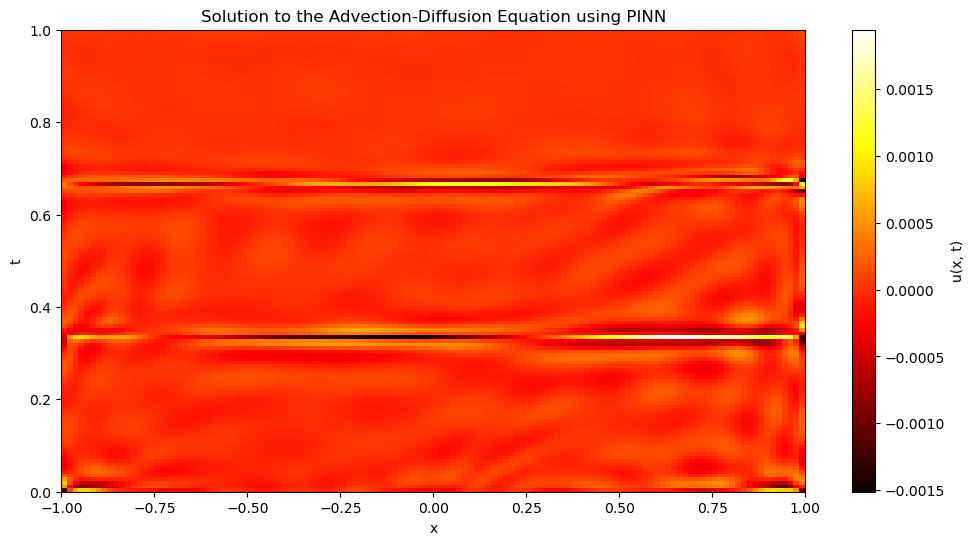

In [21]:
plt.figure(figsize=(12, 6))
plt.imshow(u_total-u_pred, extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Advection-Diffusion Equation using PINN')
plt.show()

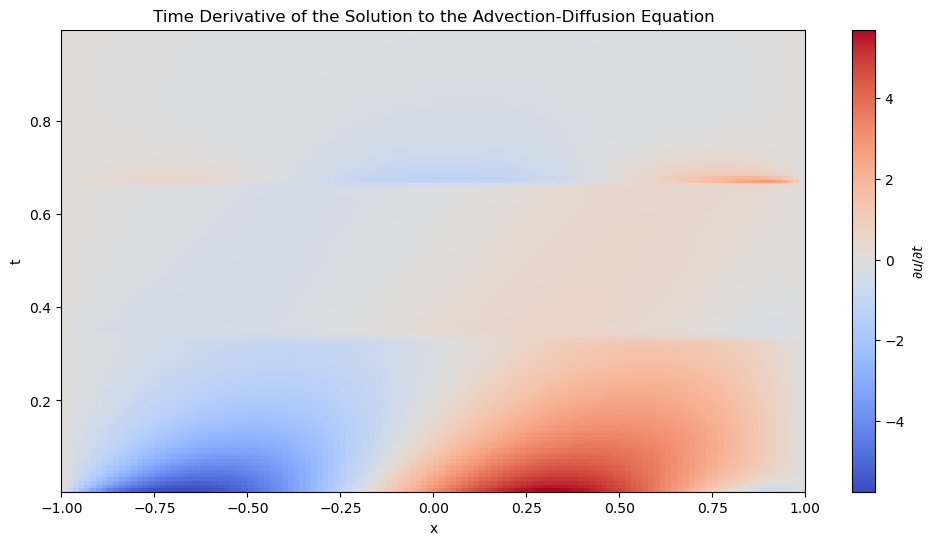

In [17]:
# Calculate the time derivative of u_total
du_pred_dt = np.diff(u_pred, axis=0) / dt  # Central difference in time

# Prepare the time vector for the derivative (midpoints between original time steps)
t_derivative = 0.5 * (t[:-1] + t[1:])

# Plot the time derivative of u_total
plt.figure(figsize=(12, 6))
plt.imshow(
    du_pred_dt,
    extent=[x_min, x_max, t_derivative[0], t_derivative[-1]],
    origin='lower',
    aspect='auto',
    cmap='coolwarm',
)
plt.colorbar(label=r'$\partial u / \partial t$')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Time Derivative of the Solution to the Advection-Diffusion Equation')
plt.show()


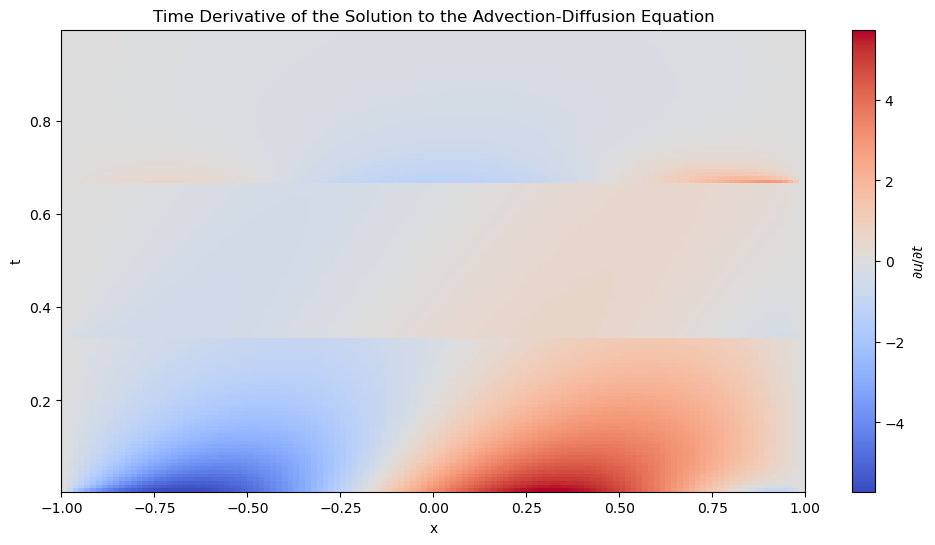

In [19]:
# Calculate the time derivative of u_total
du_total_dt = np.diff(u_total, axis=0) / dt  # Central difference in time

# Prepare the time vector for the derivative (midpoints between original time steps)
t_derivative = 0.5 * (t[:-1] + t[1:])

# Plot the time derivative of u_total
plt.figure(figsize=(12, 6))
plt.imshow(
    du_total_dt,
    extent=[x_min, x_max, t_derivative[0], t_derivative[-1]],
    origin='lower',
    aspect='auto',
    cmap='coolwarm',
)
plt.colorbar(label=r'$\partial u / \partial t$')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Time Derivative of the Solution to the Advection-Diffusion Equation')
plt.show()


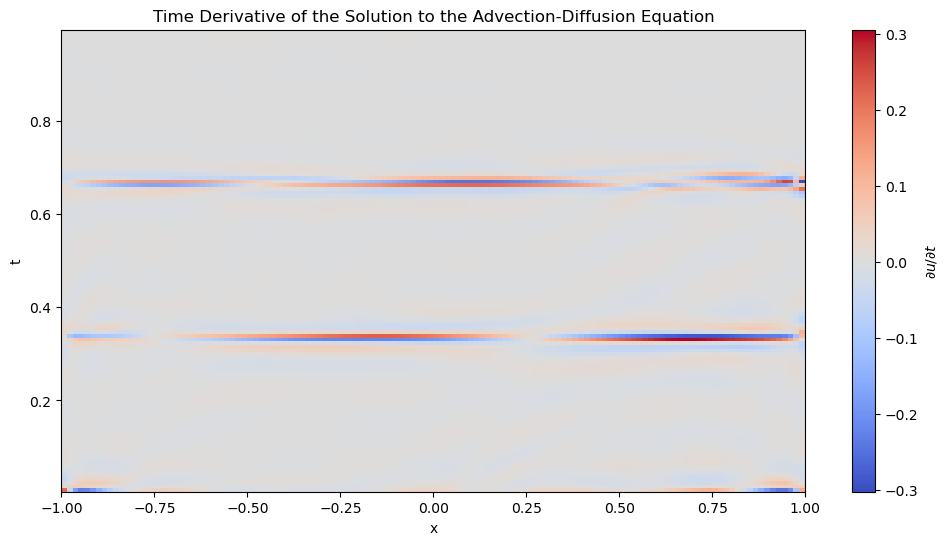

In [23]:
# Plot the time derivative of u_total
plt.figure(figsize=(12, 6))
plt.imshow(
    du_total_dt - du_pred_dt,
    extent=[x_min, x_max, t_derivative[0], t_derivative[-1]],
    origin='lower',
    aspect='auto',
    cmap='coolwarm',
)
plt.colorbar(label=r'$\partial u / \partial t$')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Time Derivative of the Solution to the Advection-Diffusion Equation')
plt.show()


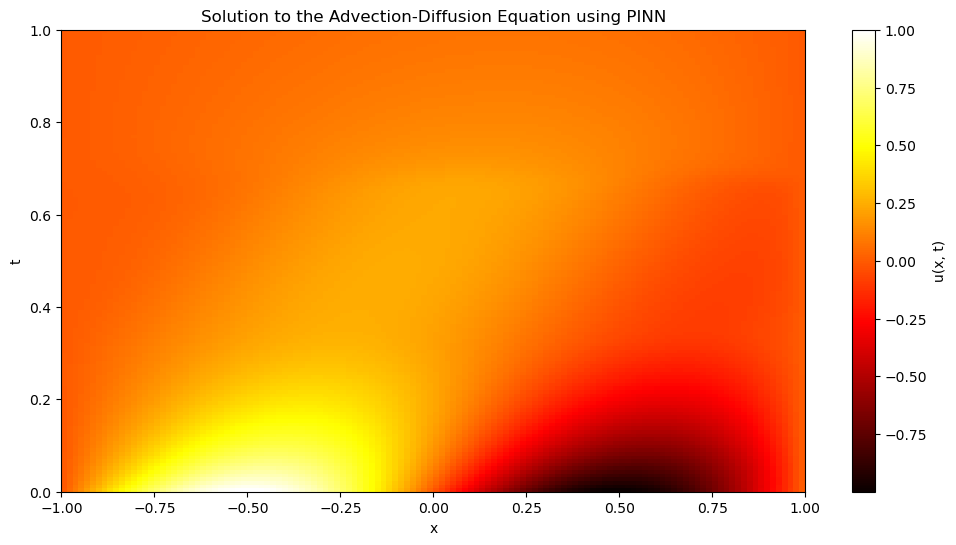

In [138]:
tensor_gelu = model_updated(x_t_grid).reshape(127,128)

# Convert the tensor to a NumPy array
tensor_np_gelu = tensor_gelu.detach().cpu().numpy()
u_pred_gelu = tensor_np_gelu
plt.figure(figsize=(12, 6))
plt.imshow(u_pred_gelu, extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Advection-Diffusion Equation using PINN')
plt.show()

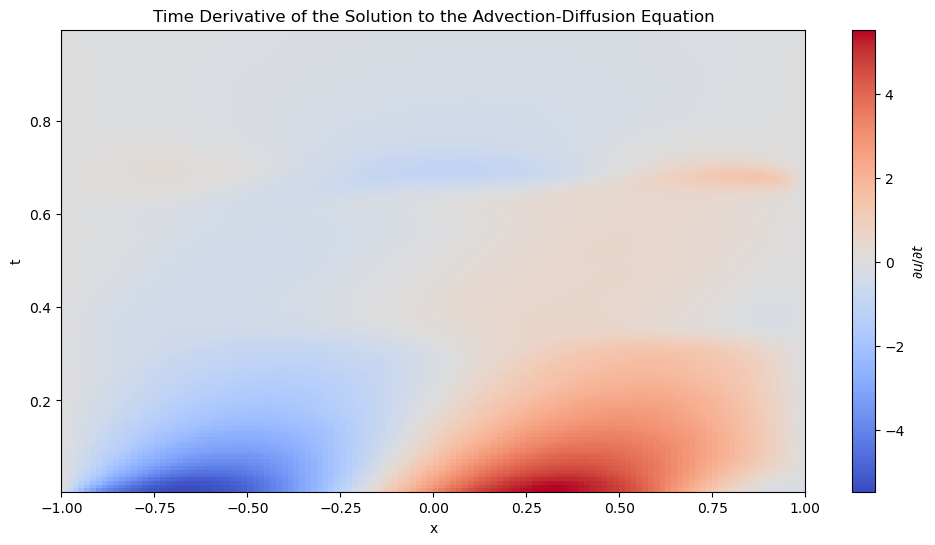

In [140]:
# Calculate the time derivative of u_total
du_pred_dt = np.diff(u_pred_gelu, axis=0) / dt  # Central difference in time

# Prepare the time vector for the derivative (midpoints between original time steps)
t_derivative = 0.5 * (t[:-1] + t[1:])

# Plot the time derivative of u_total
plt.figure(figsize=(12, 6))
plt.imshow(
    du_pred_dt,
    extent=[x_min, x_max, t_derivative[0], t_derivative[-1]],
    origin='lower',
    aspect='auto',
    cmap='coolwarm',
)
plt.colorbar(label=r'$\partial u / \partial t$')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Time Derivative of the Solution to the Advection-Diffusion Equation')
plt.show()


In [130]:
training_loss(model_updated,batch)

tensor(77.3802, device='cuda:0', grad_fn=<SumBackward0>)

In [132]:

#epochs = 10000
for epoch in range(num_epochs):
    loss = 0
    loss_pinn = 0
    loss_train = 0
    loss_lambda= 0
    for index, batch in enumerate(dataloader):
        
        x_t_batch = batch[0]
        u_batch = batch[1]
        
        #L_pinn = physics_informed_loss(model,x_t_batch)
        L_train = training_loss(model_updated,batch)
        #L_lambda = lambda_loss(lambda_param)
        
        #L_total = L_pinn + L_train + L_lambda
        
        optimizer.zero_grad()
    
        # Step 2: Compute the total loss
        #L_total = w1*L_pinn + w2*L_train + w3*L_lambda
        #loss += L_total
        #loss_pinn += L_pinn
        L_total = L_train
        loss_train += L_train
        #loss_lambda += L_lambda
        # Step 3: Backpropagate to compute gradients
        L_total.backward()
        
        # Step 4: Perform the gradient descent step
        optimizer.step()
        #w1, w2, w3 = update_weights(L_pinn.detach(), L_train.detach(), L_lambda.detach())
    if epoch%100==0:
        #print(f"epochs:{epoch} , Loss:{loss}, Losses:{loss_pinn.item(),loss_train.item(),loss_lambda.item()}, Weights:{w1.item(),w2.item(),w3.item()}")
        print(f"epochs:{epoch} , Loss:{loss_train}")
    #if epoch%1000==0:
    #    print(f"lambda:{lambda_param}")

epochs:0 , Loss:77.3802490234375
epochs:100 , Loss:0.25609633326530457
epochs:200 , Loss:0.12244916707277298
epochs:300 , Loss:0.08170637488365173
epochs:400 , Loss:0.0656421035528183
epochs:500 , Loss:0.05707475543022156
epochs:600 , Loss:0.050778649747371674
epochs:700 , Loss:0.04599102586507797
epochs:800 , Loss:0.04237663745880127
epochs:900 , Loss:0.03955930098891258
epochs:1000 , Loss:0.03706483542919159
epochs:1100 , Loss:0.03482140228152275
epochs:1200 , Loss:0.0329502671957016
epochs:1300 , Loss:0.03126216679811478
epochs:1400 , Loss:0.029682423919439316
epochs:1500 , Loss:0.028078382834792137
epochs:1600 , Loss:0.026637515053153038
epochs:1700 , Loss:0.025336116552352905
epochs:1800 , Loss:0.024127766489982605
epochs:1900 , Loss:0.02299390733242035
epochs:2000 , Loss:0.02193024754524231
epochs:2100 , Loss:0.020928505808115005
epochs:2200 , Loss:0.020009923726320267
epochs:2300 , Loss:0.019160807132720947
epochs:2400 , Loss:0.018392864614725113
epochs:2500 , Loss:0.01769228652

KeyboardInterrupt: 

In [136]:
L_total

tensor(0.0138, device='cuda:0', grad_fn=<SumBackward0>)

In [142]:
# Filepath to save the model
model_save_path = "gelu_pinn_model.pth"

# Save the model's state_dict (parameters)
torch.save({
    'model_state_dict': model_updated.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': loss_train,
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to gelu_pinn_model.pth


In [160]:
# Initialize the model
# Freeze all parameters
for param in model_updated.parameters():
    param.requires_grad = False
    
lambda_param = nn.Parameter(torch.ones(Nt_combined, device=device, requires_grad=True))


In [168]:
optimizer = optim.Adam([lambda_param], lr=0.001)

In [162]:
# Compute the physics-informed loss
def physics_informed_loss(model, x_t):
    x_t.requires_grad = True
    u = model(x_t)
    
    # Compute gradients for ∂u/∂t and ∂u/∂x
    grads = torch.autograd.grad(u, x_t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[..., 1]
    u_x = grads[..., 0]
    
    # Compute the second derivative ∂²u/∂x²
    u_x_grad = torch.autograd.grad(u_x, x_t, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xx = u_x_grad[..., 0]
    
    #u_xx = u_xx
    #u_xx_trans = u_xx.t()
    diffusion = lambda_param*u_xx
    #diffusion = diffusion.view(-1)
    advection_diffusion_loss = u_t + u_x - diffusion

    return torch.mean(advection_diffusion_loss ** 2)

In [164]:
import torch
import torch.nn.functional as F

def lambda_loss(lambda_param):
    T = t_grid[-1] - t_grid[0]
    # Define delta(t) as sqrt(T / (T - t))
    delta_t = torch.sqrt(T / ((t_grid+0.001)*(T - t_grid)))
    delta_t = delta_t[...,0]
    # Calculate Δλ as λ(t^{i+1}) - λ(t^i)
    delta_lambda = lambda_param[1:] - lambda_param[:-1]
    
    # Compute Δλ⁺ and Δλ⁻ using ReLU for positive and negative parts
    delta_lambda_plus = F.relu(delta_lambda)              # ReLU for Δλ⁺
    delta_lambda_minus = F.relu(-delta_lambda)            # ReLU for Δλ⁻

    # Calculate V_lambda according to the given summation formula
    V_lambda = torch.sum(delta_t[:-1] * (delta_lambda_plus + delta_lambda_minus))

    return V_lambda
lambda_loss(lambda_param)

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [170]:
#w1 = torch.tensor(1/3, dtype=torch.float32, device=device)
#w2 = torch.tensor(1/3, dtype=torch.float32, device=device)
#w3 = torch.tensor(1/3, dtype=torch.float32, device=device)
#epochs = 10000
for epoch in range(num_epochs):
    loss = 0
    loss_pinn = 0
    loss_train = 0
    loss_lambda= 0
    for index, batch in enumerate(dataloader):
        
        x_t_batch = batch[0]
        u_batch = batch[1]
        
        L_pinn = physics_informed_loss(model,x_t_batch)
        #L_train = training_loss(model,batch)
        L_lambda = lambda_loss(lambda_param)
        
        #L_total = L_pinn + L_train + L_lambda
        
        optimizer.zero_grad()
    
        # Step 2: Compute the total loss
        L_total = L_pinn + L_lambda
        loss += L_total
        loss_pinn += L_pinn
        #loss_train += L_train
        loss_lambda += L_lambda
        # Step 3: Backpropagate to compute gradients
        L_total.backward()
        
        # Step 4: Perform the gradient descent step
        optimizer.step()
        #w1, w2, w3 = update_weights(L_pinn.detach(), L_train.detach(), L_lambda.detach())
    if epoch%100==0:
        print(f"epochs:{epoch} , Loss:{loss}, Losses:{loss_pinn.item(),loss_lambda.item()}")
        
    if epoch%1000==0:
        print(f"lambda:{lambda_param}")

epochs:0 , Loss:1.4556941986083984, Losses:(1.4466278553009033, 0.009066307917237282)
lambda:Parameter containing:
tensor([0.9991, 0.9971, 0.9991, 0.9972, 0.9992, 0.9991, 0.9972, 0.9992, 0.9972,
        0.9972, 0.9992, 0.9973, 0.9992, 0.9973, 0.9993, 0.9973, 0.9974, 0.9974,
        0.9994, 0.9974, 0.9975, 0.9975, 0.9995, 0.9995, 0.9976, 0.9976, 0.9996,
        0.9976, 0.9978, 0.9978, 0.9998, 0.9978, 0.9978, 0.9979, 0.9979, 0.9980,
        0.9980, 0.9980, 1.0000, 0.9980, 0.9981, 0.9981, 0.9982, 0.9982, 1.0002,
        0.9982, 0.9983, 0.9983, 1.0003, 0.9983, 1.0003, 0.9983, 0.9983, 0.9984,
        0.9984, 0.9984, 0.9984, 0.9985, 1.0005, 1.0005, 1.0005, 0.9986, 0.9986,
        1.0005, 1.0005, 1.0006, 1.0006, 1.0006, 1.0006, 1.0007, 0.9987, 1.0006,
        1.0007, 1.0007, 0.9987, 0.9987, 1.0007, 1.0007, 1.0007, 0.9987, 0.9987,
        1.0007, 0.9987, 1.0007, 1.0007, 1.0007, 0.9987, 0.9987, 1.0007, 1.0007,
        1.0007, 0.9988, 0.9987, 1.0007, 0.9987, 0.9987, 0.9987, 1.0007, 1.0007,
     

KeyboardInterrupt: 

In [172]:
# Define the lambda_param with specific values for each third
lambda_param = torch.cat([
    torch.full((Nt_combined // 3,), 0.5, device=device),  # First third
    torch.full((Nt_combined // 3,), 0.05, device=device), # Second third
    torch.full((Nt_combined - 2 * (Nt_combined // 3),), 0.1, device=device)  # Remaining third
], dim=0).requires_grad_(True)  # Ensure the tensor has gradients enabled


In [176]:
lambda_param.shape

torch.Size([127])

In [178]:
Nt_combined

127

In [180]:
physics_informed_loss(model_updated,x_t_batch)

tensor(0.1852, device='cuda:0', grad_fn=<MeanBackward0>)

In [278]:
u.shape

torch.Size([16256, 1])

In [171]:
# Compute the physics-informed loss
x_t_grid.requires_grad = True
u = model_updated(x_t_grid)

# Compute gradients for ∂u/∂t and ∂u/∂x
grads = torch.autograd.grad(u, x_t_grid, grad_outputs=torch.ones_like(u), create_graph=True)[0]
u_t = grads[:, 1]
u_x = grads[:, 0]

# Compute the second derivative ∂²u/∂x²
u_x_grad = torch.autograd.grad(u_x, x_t_grid, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
u_xx = u_x_grad[:, 0]
u_t = u_t.reshape(127,128)
u_x = u_x.reshape(127,128)
u_xx = u_xx.reshape(127,128)

u_xx_trans = u_xx.t()
diffusion = lambda_param*u_xx_trans
diffusion = diffusion.t()
#diffusion = diffusion.view(-1)
advection_diffusion_loss = u_t + u_x - diffusion

NameError: name 'lambda_param' is not defined

In [173]:
# Compute the physics-informed loss
x_t_grid.requires_grad = True
u = model_updated(x_t_grid)

# Compute gradients for ∂u/∂t and ∂u/∂x
grads = torch.autograd.grad(u, x_t_grid, grad_outputs=torch.ones_like(u), create_graph=True)[0]
u_t = grads[:, 1]
u_x = grads[:, 0]

# Compute the second derivative ∂²u/∂x²
u_x_grad = torch.autograd.grad(u_x, x_t_grid, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
u_xx = u_x_grad[:, 0]
u_t = u_t.reshape(127,128)
u_x = u_x.reshape(127,128)
u_xx = u_xx.reshape(127,128)


In [199]:
(u_t+u_x)/u_xx

tensor([[ 0.0927,  0.7755,  1.0897,  ...,  2.2395,  0.6187, -0.7113],
        [ 0.1156,  0.6508,  0.9815,  ...,  0.7395,  0.4589, -0.4639],
        [ 0.1450,  0.6316,  0.8095,  ...,  0.5554,  0.4763, -0.3386],
        ...,
        [ 2.3548,  1.3728,  1.0921,  ...,  1.8152,  2.2841,  2.9182],
        [ 2.3451,  1.4061,  1.1413,  ...,  1.5487,  2.0307,  2.7069],
        [ 2.4047,  1.4702,  1.2132,  ...,  1.3192,  1.7517,  2.3718]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [201]:
tensor = (u_x+u_t)/u_xx

In [203]:
tensor.shape

torch.Size([127, 128])

In [211]:
row_means = tensor.mean(dim=1)
a = row_means[0:43].mean()
b = row_means[43:84].mean()
c = row_means[84:128].mean()
print(a,b,c)

tensor(0.4444, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0496, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2.0575, device='cuda:0', grad_fn=<MeanBackward0>)


In [225]:
for j in range(row_means.shape[0]):
    print(row_means[j].item())

0.5030958652496338
0.51600182056427
0.5109055042266846
0.4924076795578003
0.5442728996276855
0.3959251642227173
0.49062544107437134
0.3690490126609802
0.5131100416183472
0.4459722638130188
0.40592876076698303
0.2967531085014343
-0.895966649055481
-0.11233952641487122
0.5407726764678955
0.4846959412097931
0.4841163754463196
0.446824312210083
0.4721032381057739
0.4168812036514282
0.46435311436653137
0.23449115455150604
0.5089897513389587
0.5802728533744812
0.5017656683921814
0.6531362533569336
0.46340417861938477
0.589724063873291
0.7142727375030518
0.7693842649459839
0.6210864186286926
0.5206547975540161
0.5212843418121338
0.5249732732772827
0.37841254472732544
0.4884926676750183
0.4903936982154846
0.4921402037143707
0.757493793964386
0.4649796485900879
0.3624473214149475
0.41819941997528076
0.2689931392669678
0.1192333847284317
0.056656137108802795
0.05201484635472298
0.04505637288093567
0.04423566162586212
0.055601783096790314
0.03611232340335846
0.05493323504924774
0.0444619432091712

In [204]:
u_x

tensor([[-0.4122, -0.3343, -0.3763,  ..., -0.0781, -0.0634, -0.0613],
        [ 2.9397,  2.9223,  2.9191,  ..., -0.2030, -0.1869, -0.1869],
        [ 2.6435,  2.6271,  2.6267,  ..., -0.1401, -0.1287, -0.1802],
        ...,
        [-2.3064, -2.2435, -2.1531,  ..., -0.0079, -0.0079, -0.0114],
        [ 1.1897,  1.2021,  1.1845,  ...,  0.1048,  0.1048,  0.0667],
        [ 2.8090,  2.6568,  2.6025,  ...,  0.0824,  0.0823,  0.0823]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [438]:
u_x.shape

torch.Size([127, 128])

In [440]:
import torch
import numpy as np

# Define the spatial grid
x_min = -1.0
x_max = 1.0
Nx = 128
x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]

# Assuming u_x is already defined on the GPU with shape [127, 128]
# u_x = torch.randn(127, 128, device='cuda')  # Example tensor on GPU

# Compute the derivative of u_x with respect to x using finite differences
# Central difference for interior points and forward/backward difference for boundaries
du_dx = torch.zeros_like(u_x, device='cuda')  # Initialize the derivative tensor

# Central difference for interior points
du_dx[:, 1:-1] = (u_x[:, 2:] - u_x[:, :-2]) / (2 * dx)

# Forward difference for the first spatial point
du_dx[:, 0] = (u_x[:, 1] - u_x[:, 0]) / dx

# Backward difference for the last spatial point
du_dx[:, -1] = (u_x[:, -1] - u_x[:, -2]) / dx

# du_dx now contains the derivative with respect to x


In [444]:
u_xx

tensor([[ 2.1436e+01,  4.6146e+00,  9.1675e-01,  ...,  6.7194e+00,
          3.4901e+00, -1.1937e+01],
        [ 1.7119e+01,  4.5372e+00,  8.6681e-01,  ...,  6.9593e+00,
          3.8597e+00, -1.2022e+01],
        [ 1.3046e+01,  4.5158e+00,  1.0645e+00,  ...,  7.3108e+00,
          4.1464e+00, -1.2208e+01],
        ...,
        [ 3.9171e-02,  2.3763e-02, -1.1681e-02,  ...,  3.3495e-01,
          5.6157e-01,  5.7599e-01],
        [ 3.2750e-02,  1.2559e-02, -2.5756e-02,  ...,  3.2647e-01,
          5.4976e-01,  5.7075e-01],
        [ 2.4615e-02,  8.7526e-05, -4.0009e-02,  ...,  3.1730e-01,
          5.3783e-01,  5.6624e-01]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [442]:
du_dx

tensor([[ 1.2565e+01,  7.3834e+00,  1.0841e+00,  ...,  6.1506e+00,
          8.5312e-01, -4.6105e+00],
        [ 1.0973e+01,  6.4834e+00,  1.3351e+00,  ...,  6.4519e+00,
          1.1221e+00, -4.2704e+00],
        [ 9.1544e+00,  5.6573e+00,  1.6029e+00,  ...,  6.8178e+00,
          1.3467e+00, -4.0538e+00],
        ...,
        [ 3.3391e-02,  2.0365e-02, -1.3065e-02,  ...,  3.1951e-01,
          5.2524e-01,  5.8929e-01],
        [ 2.4513e-02,  9.4821e-03, -2.6534e-02,  ...,  3.1414e-01,
          5.1512e-01,  5.8055e-01],
        [ 1.4086e-02, -2.5548e-03, -4.0139e-02,  ...,  3.0801e-01,
          5.0492e-01,  5.7207e-01]], device='cuda:0', grad_fn=<CopySlices>)

In [216]:
tensor = (u_x+u_t)/du_dx

In [218]:
torch.set_printoptions(profile="full")

# Print the tensor
print(tensor)

# Reset print options to default after displaying
torch.set_printoptions(profile="default")

tensor([[ 2.1194e-02,  2.3269e-02,  2.3182e-02,  1.9708e-02,  1.9933e-02,
          1.7446e-02,  1.9013e-02,  1.7422e-02,  1.6844e-02,  1.6098e-02,
          1.6092e-02,  1.6923e-02,  1.4845e-02,  1.5014e-02,  1.5275e-02,
          1.5332e-02,  1.5942e-02,  1.4198e-02,  1.4601e-02,  1.4591e-02,
          1.4286e-02,  1.4325e-02,  1.4318e-02,  1.4567e-02,  1.3171e-02,
          1.1970e-02,  1.3332e-02,  1.2783e-02,  1.2866e-02,  1.1196e-02,
          1.1176e-02,  1.2670e-02,  1.1450e-02,  1.1853e-02,  1.1716e-02,
          1.0801e-02,  1.0784e-02,  1.0394e-02,  1.0373e-02,  1.0797e-02,
          9.6709e-03,  9.2390e-03,  6.0982e-03,  3.4214e-03,  4.9792e-03,
          1.0397e-03,  4.3917e-04,  5.9361e-04,  5.8683e-04,  5.8006e-04,
          5.6851e-04,  5.6105e-04,  3.5870e-04,  1.6326e-04,  1.7278e-03,
          7.9557e-04,  7.8711e-04,  1.6350e-03,  1.5009e-03,  1.4922e-03,
          1.5094e-04,  1.4376e-04,  1.2664e-04,  1.1373e-04,  1.4798e-03,
          1.4704e-03,  1.4610e-03,  7.

In [306]:
u_numpy = u_total.T

In [424]:
u_tensor = u.reshape(127,128)

In [428]:
u_numpy.shape

(128, 127)

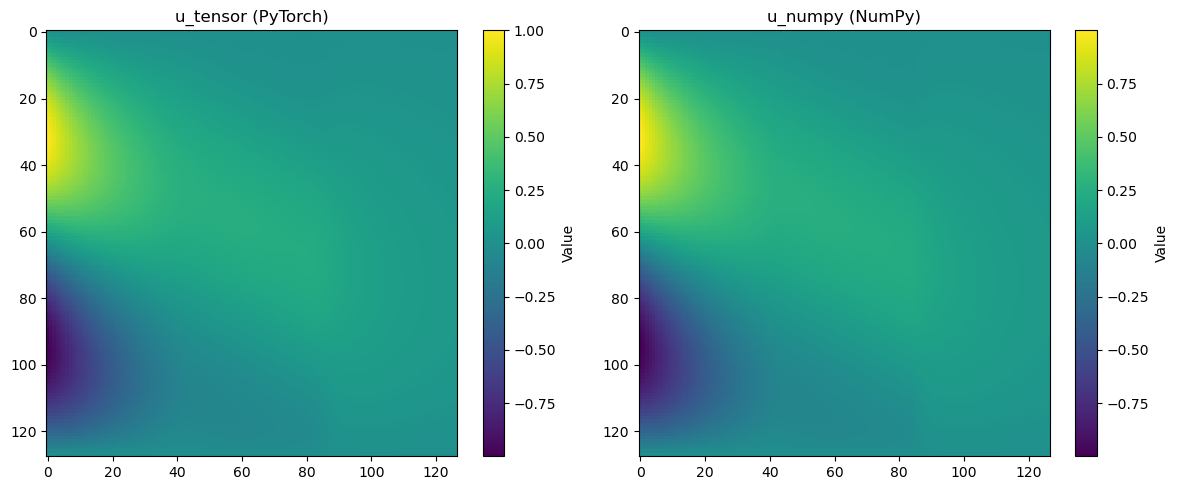

In [436]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming u is a PyTorch tensor on GPU
# Example tensor: u = torch.randn((50, 50, 2), device='cuda')
u_tensor = u_tensor.clone().detach()  # Detach and clone the tensor

# Convert u_tensor to NumPy
u_tensor_cpu = u_tensor.cpu().numpy()
u_tensor_cpu = u_tensor_cpu.T

# Example NumPy array (replace with your actual data)
# u_numpy = np.random.randn(50, 50)

# Plotting
plt.figure(figsize=(12, 5))

# Plot the PyTorch tensor as a heatmap
plt.subplot(1, 2, 1)
plt.imshow(u_tensor_cpu, aspect='auto', cmap='viridis')
plt.title("u_tensor (PyTorch)")
plt.colorbar(label='Value')

# Plot the NumPy array as a heatmap
plt.subplot(1, 2, 2)
plt.imshow(u_numpy, aspect='auto', cmap='viridis')
plt.title("u_numpy (NumPy)")
plt.colorbar(label='Value')

# Show the plots
plt.tight_layout()
plt.show()


In [342]:
u_numpy.shape

(128, 127)

In [340]:
u_tensor_cpu.shape

(128, 127)

In [354]:
x_t_grid_2d = x_t_grid.reshape(127,128,2)

In [364]:
x_t_grid_2d

tensor([[[-1.0000,  0.0000],
         [-0.9843,  0.0000],
         [-0.9685,  0.0000],
         ...,
         [ 0.9685,  0.0000],
         [ 0.9843,  0.0000],
         [ 1.0000,  0.0000]],

        [[-1.0000,  0.0079],
         [-0.9843,  0.0079],
         [-0.9685,  0.0079],
         ...,
         [ 0.9685,  0.0079],
         [ 0.9843,  0.0079],
         [ 1.0000,  0.0079]],

        [[-1.0000,  0.0159],
         [-0.9843,  0.0159],
         [-0.9685,  0.0159],
         ...,
         [ 0.9685,  0.0159],
         [ 0.9843,  0.0159],
         [ 1.0000,  0.0159]],

        ...,

        [[-1.0000,  0.9841],
         [-0.9843,  0.9841],
         [-0.9685,  0.9841],
         ...,
         [ 0.9685,  0.9841],
         [ 0.9843,  0.9841],
         [ 1.0000,  0.9841]],

        [[-1.0000,  0.9921],
         [-0.9843,  0.9921],
         [-0.9685,  0.9921],
         ...,
         [ 0.9685,  0.9921],
         [ 0.9843,  0.9921],
         [ 1.0000,  0.9921]],

        [[-1.0000,  1.0000],
       

In [374]:
u_reshaped = u.reshape(127,128)

In [376]:
u_reshaped.shape

torch.Size([127, 128])

In [378]:
x_t_grid.requires_grad = True
u = model_updated(x_t_grid)

# Compute gradients for ∂u/∂t and ∂u/∂x
grads = torch.autograd.grad(u, x_t_grid, grad_outputs=torch.ones_like(u), create_graph=True)[0]
grads

tensor([[ 2.8906, -0.3437],
        [ 3.0885, -0.9697],
        [ 3.1232, -1.6103],
        ...,
        [-0.1880, -0.0455],
        [-0.1812, -0.0381],
        [-0.1721, -0.0309]], device='cuda:0', grad_fn=<MmBackward0>)

In [386]:
x_t_grid

tensor([[-1.0000,  0.0000],
        [-0.9843,  0.0000],
        [-0.9685,  0.0000],
        ...,
        [ 0.9685,  1.0000],
        [ 0.9843,  1.0000],
        [ 1.0000,  1.0000]], device='cuda:0', requires_grad=True)